## Time-series based analysis of Earthquake Risk Factors

### Part 3: Performing EDA on the pickled reddit dataset

In this notebook, I explore several aspects of the dataframe and also prepare the dataframe objects for further modeling.

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

### Part 2.1: Importing the saved clean data from loma prieta earthquake

In [2]:
file_path = "../datasets/" + "eq_loma_prieta" + "_clean" + ".csv"

df_lp_eq = pd.read_csv(file_path)
df_lp_eq.drop(columns = "Unnamed: 0", inplace = True)

df_lp_eq.set_index('time', inplace=True)




df_lp_eq.head()

,index,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
time,,,,,,,,,,,,,,,,
1989-10-18 23:52:57.010,0,earthquake,1.42,Northern California,reviewed,0,31,nc,11.0,0.02342,0.03,70.0,md,-121.945167,37.148333,6.129
1989-10-18 23:50:19.750,1,earthquake,1.85,Northern California,reviewed,0,53,nc,22.0,0.02523,0.05,74.0,md,-121.723333,36.965000,13.466
1989-10-18 23:42:27.610,2,earthquake,1.98,Northern California,reviewed,0,60,nc,35.0,0.02973,0.07,55.0,md,-122.032833,37.194500,11.406
1989-10-18 23:37:54.640,3,earthquake,2.09,Northern California,reviewed,0,67,nc,28.0,0.02252,0.05,69.0,md,-121.854167,37.092500,7.679
1989-10-18 23:33:41.010,4,earthquake,1.65,Northern California,reviewed,0,42,nc,17.0,0.03423,0.07,59.0,md,-121.636333,36.985500,0.856


Checking for datatypes or missing values!

In [3]:
df_lp_eq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1271 entries, 1989-10-18 23:52:57.010 to 1989-10-09 01:38:42.380
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1271 non-null   int64  
 1   type       1271 non-null   object 
 2   mag        1271 non-null   float64
 3   place      1271 non-null   object 
 4   status     1271 non-null   object 
 5   tsunami    1271 non-null   int64  
 6   sig        1271 non-null   int64  
 7   net        1271 non-null   object 
 8   nst        1270 non-null   float64
 9   dmin       1153 non-null   float64
 10  rms        1270 non-null   float64
 11  gap        1270 non-null   float64
 12  magType    1271 non-null   object 
 13  longitude  1271 non-null   float64
 14  latitude   1271 non-null   float64
 15  depth      1271 non-null   float64
dtypes: float64(8), int64(3), object(5)
memory usage: 168.8+ KB


Taking care of time index!

In [4]:
df_lp_eq.index = pd.to_datetime(df_lp_eq.index)

df_lp_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1271 entries, 1989-10-18 23:52:57.010000 to 1989-10-09 01:38:42.380000
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      1271 non-null   int64  
 1   type       1271 non-null   object 
 2   mag        1271 non-null   float64
 3   place      1271 non-null   object 
 4   status     1271 non-null   object 
 5   tsunami    1271 non-null   int64  
 6   sig        1271 non-null   int64  
 7   net        1271 non-null   object 
 8   nst        1270 non-null   float64
 9   dmin       1153 non-null   float64
 10  rms        1270 non-null   float64
 11  gap        1270 non-null   float64
 12  magType    1271 non-null   object 
 13  longitude  1271 non-null   float64
 14  latitude   1271 non-null   float64
 15  depth      1271 non-null   float64
dtypes: float64(8), int64(3), object(5)
memory usage: 168.8+ KB


In [5]:
df_lp_eq.head()

,index,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
time,,,,,,,,,,,,,,,,
1989-10-18 23:52:57.010,0,earthquake,1.42,Northern California,reviewed,0,31,nc,11.0,0.02342,0.03,70.0,md,-121.945167,37.148333,6.129
1989-10-18 23:50:19.750,1,earthquake,1.85,Northern California,reviewed,0,53,nc,22.0,0.02523,0.05,74.0,md,-121.723333,36.965000,13.466
1989-10-18 23:42:27.610,2,earthquake,1.98,Northern California,reviewed,0,60,nc,35.0,0.02973,0.07,55.0,md,-122.032833,37.194500,11.406
1989-10-18 23:37:54.640,3,earthquake,2.09,Northern California,reviewed,0,67,nc,28.0,0.02252,0.05,69.0,md,-121.854167,37.092500,7.679
1989-10-18 23:33:41.010,4,earthquake,1.65,Northern California,reviewed,0,42,nc,17.0,0.03423,0.07,59.0,md,-121.636333,36.985500,0.856


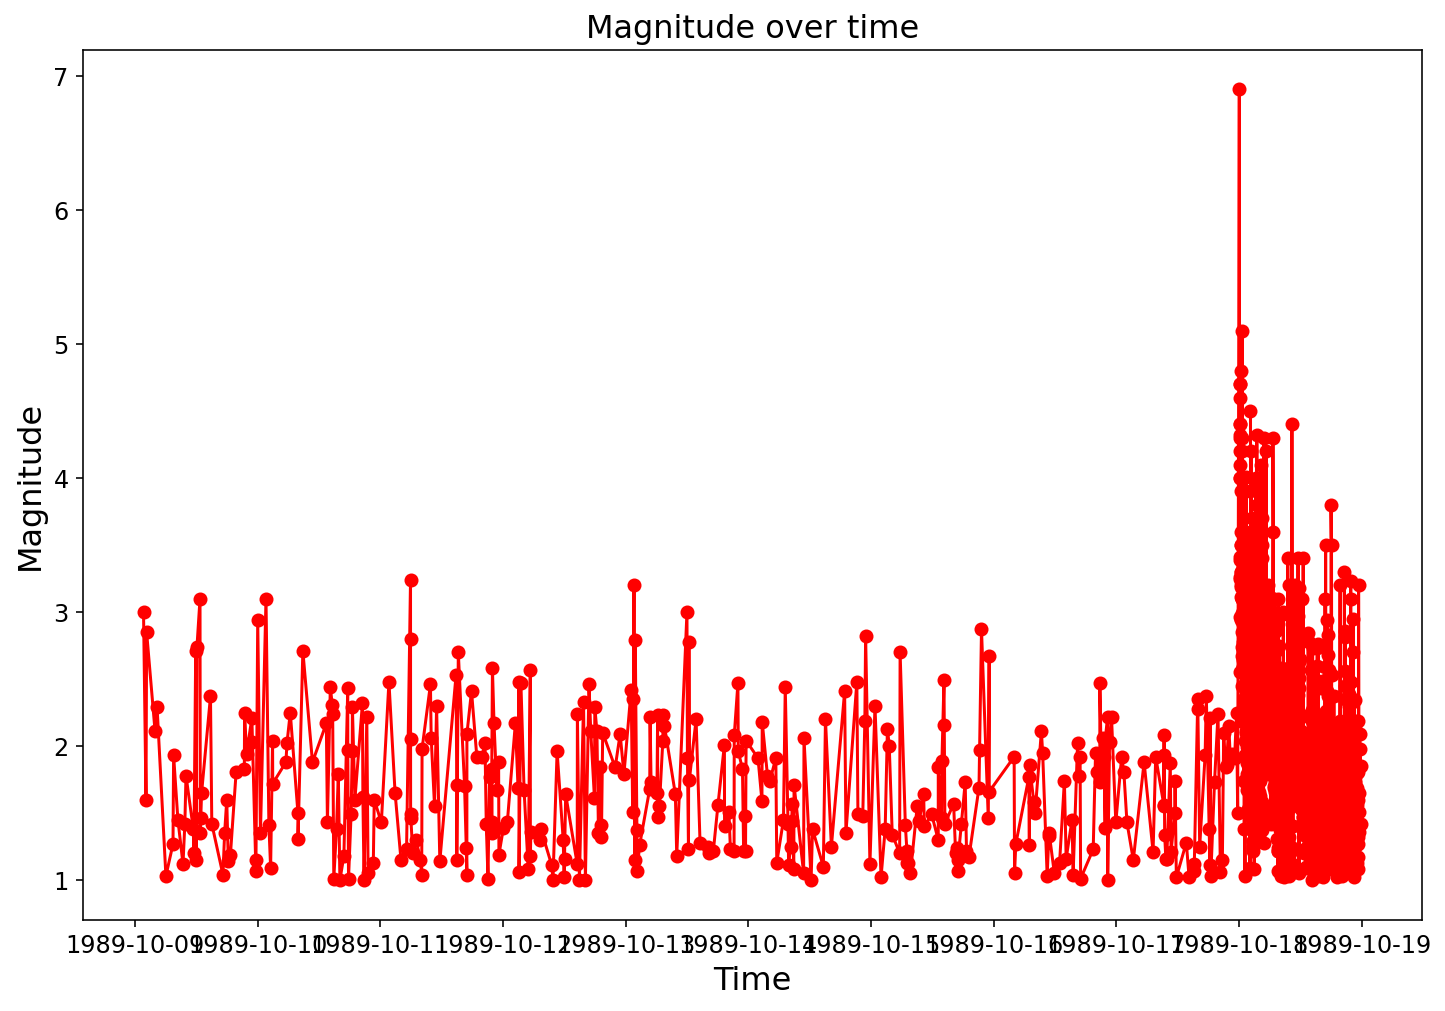

In [6]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_lp_eq["mag"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)

plt.title('Magnitude over time', fontsize=16);

Figure suggests that the main shock, which had magnitude of 7 was just a spike in magnitude domain!

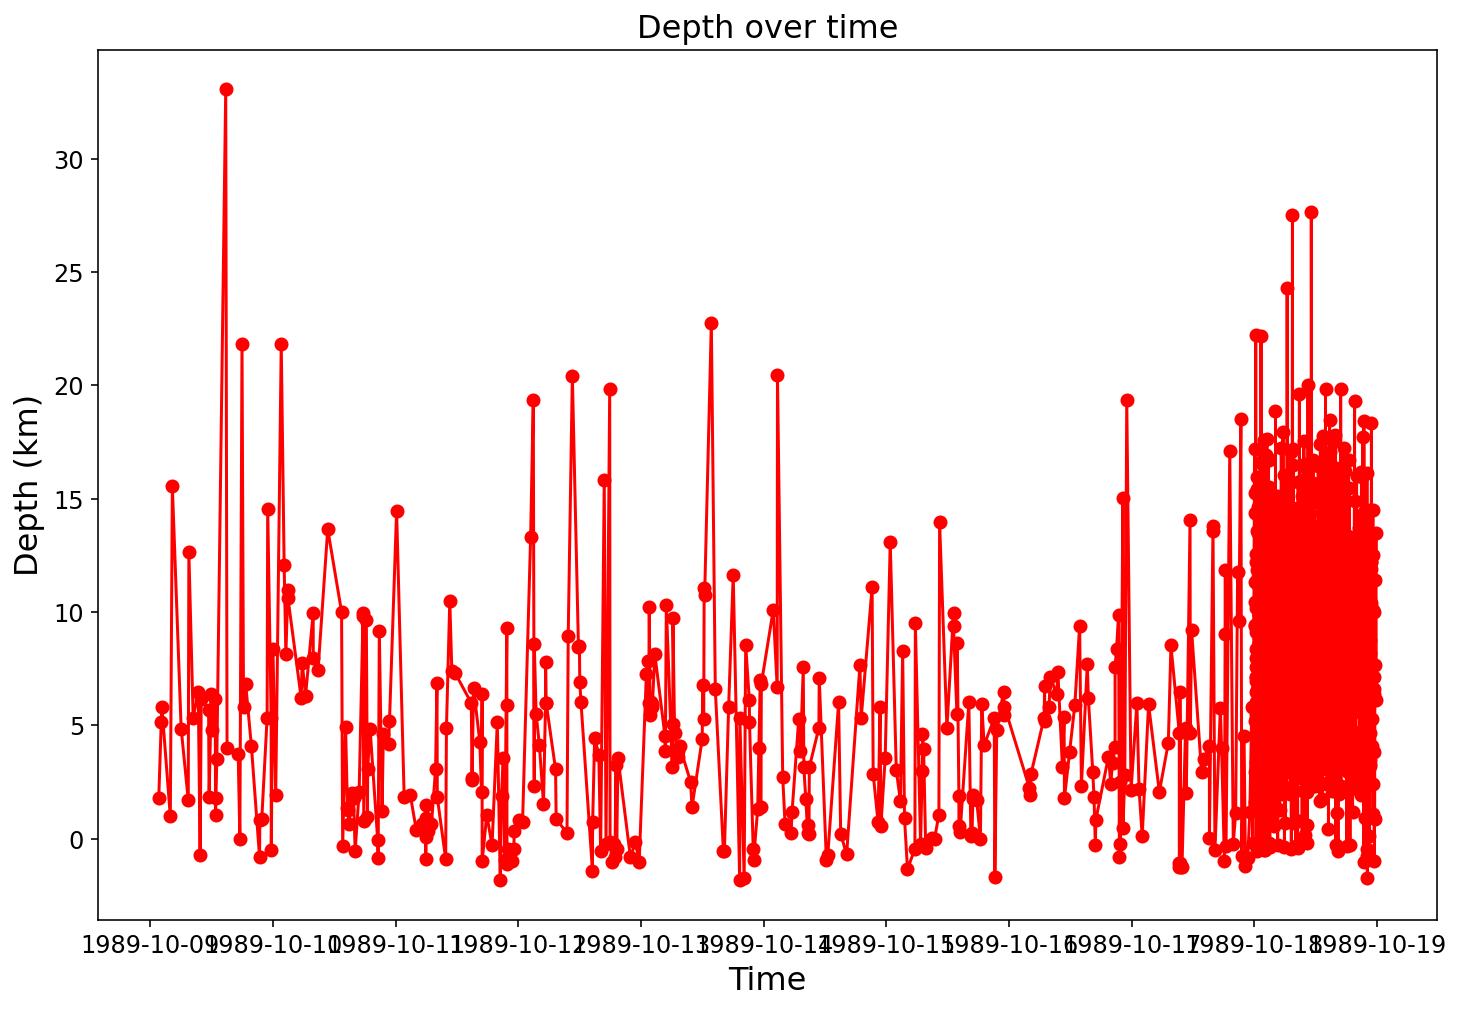

In [7]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_lp_eq["depth"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (km)', fontsize=16)
plt.title('Depth over time', fontsize=16);

Same goes for depth!

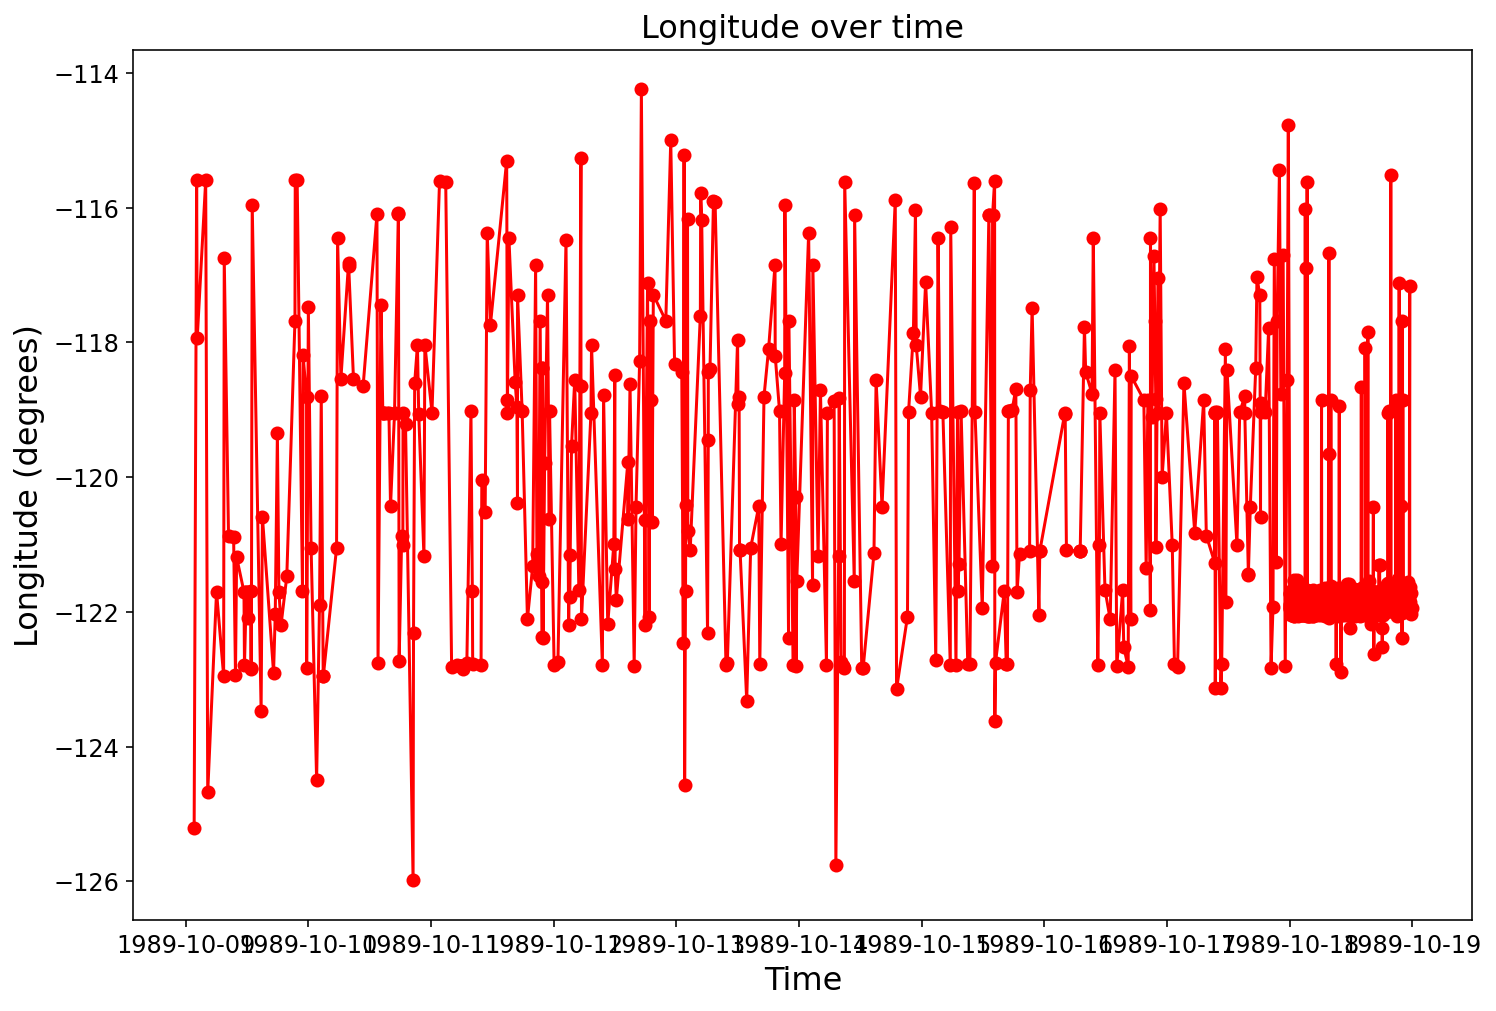

In [8]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_lp_eq["longitude"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Longitude (degrees)', fontsize=16)
plt.title('Longitude over time', fontsize=16);

Same goes for Longitude!

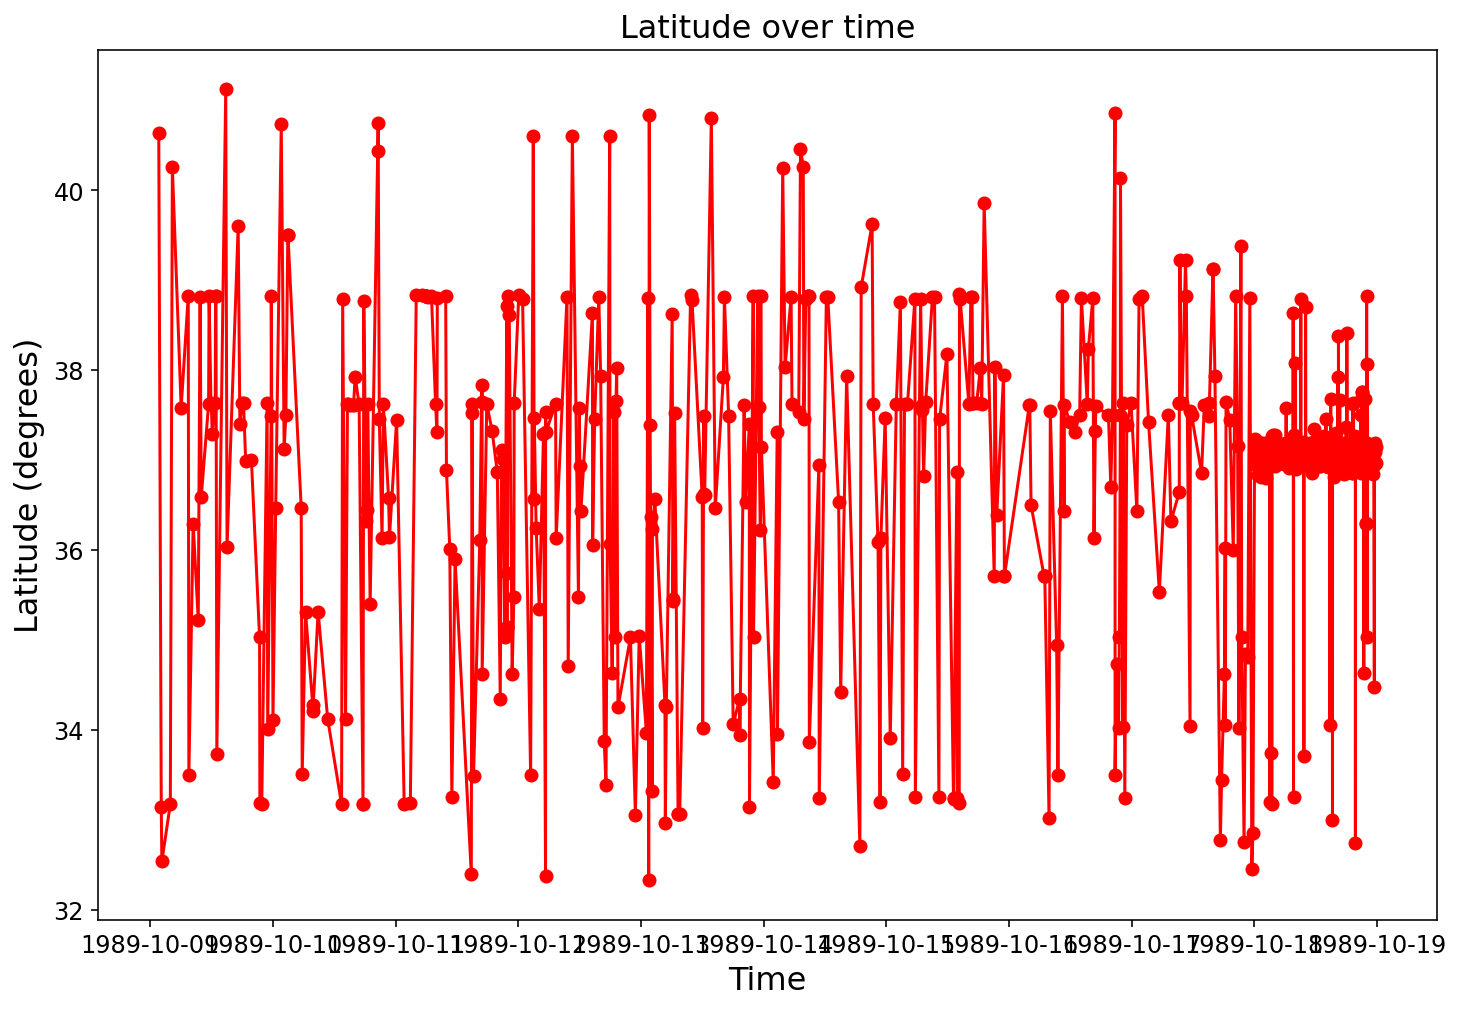

In [9]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_lp_eq["latitude"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Latitude (degrees)', fontsize=16)
plt.title('Latitude over time', fontsize=16);

Same goes for depth!

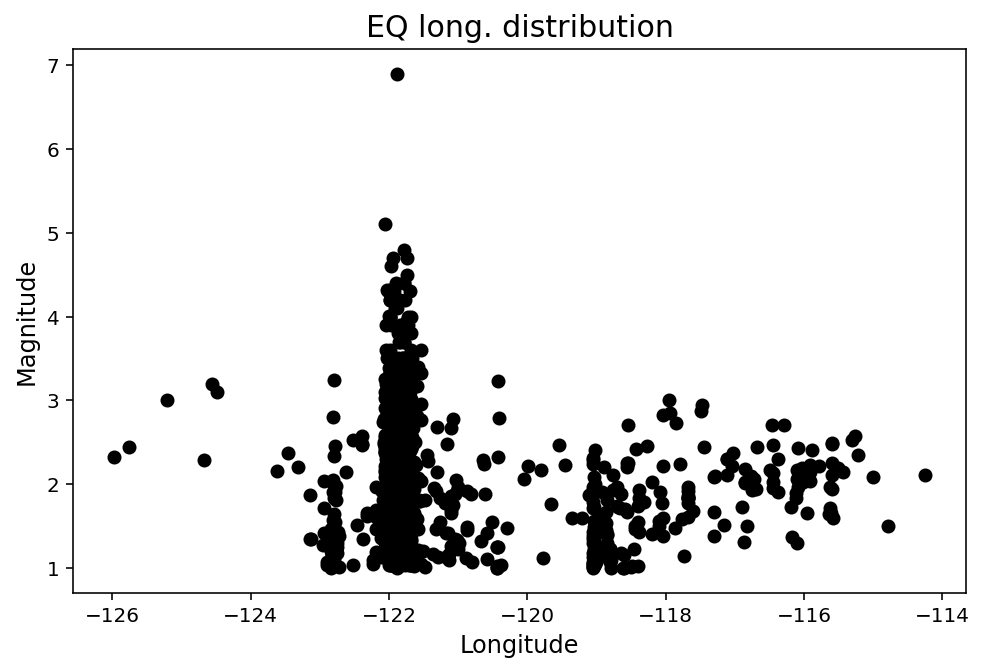

In [10]:
plt.figure(figsize = [8, 5])

plt.scatter(df_lp_eq["longitude"], df_lp_eq["mag"], color="black");

# Format title and axis labels
plt.title("EQ long. distribution", fontsize = 15);

plt.xlabel("Longitude", fontsize = 12);
plt.ylabel("Magnitude", fontsize = 12);

In addition to the main fault activites, there was a parallel fault (presumably) active as well!

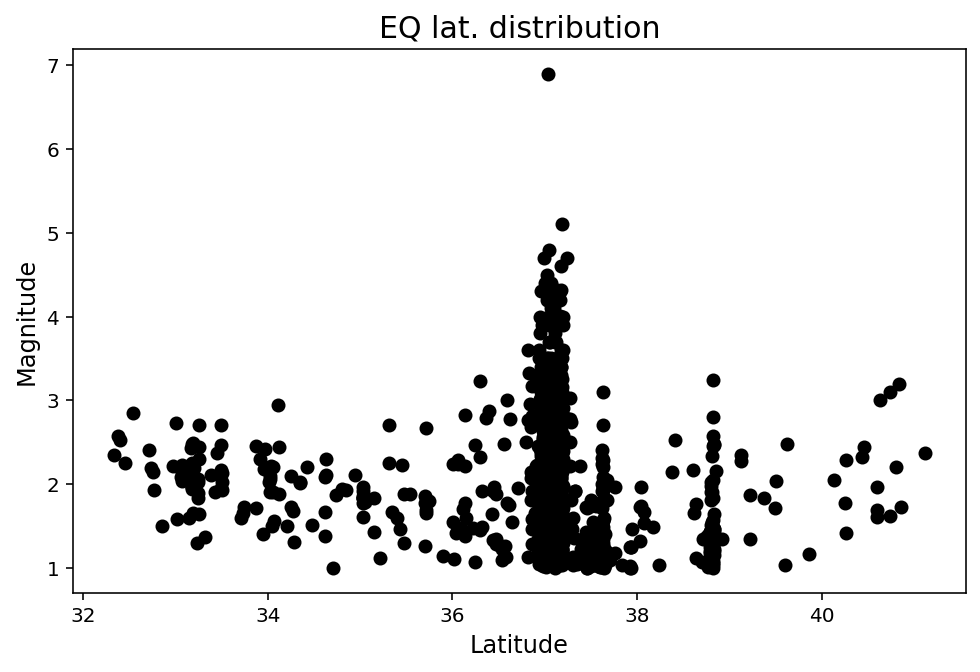

In [11]:
plt.figure(figsize = [8, 5])

plt.scatter(df_lp_eq["latitude"], df_lp_eq["mag"], color="black");

# Format title and axis labels
plt.title("EQ lat. distribution", fontsize = 15);

plt.xlabel("Latitude", fontsize = 12);
plt.ylabel("Magnitude", fontsize = 12);

In addition to the main fault activites, there was a parallel fault (presumably) active as well!

### Now, looking at tempral earthquake focus points

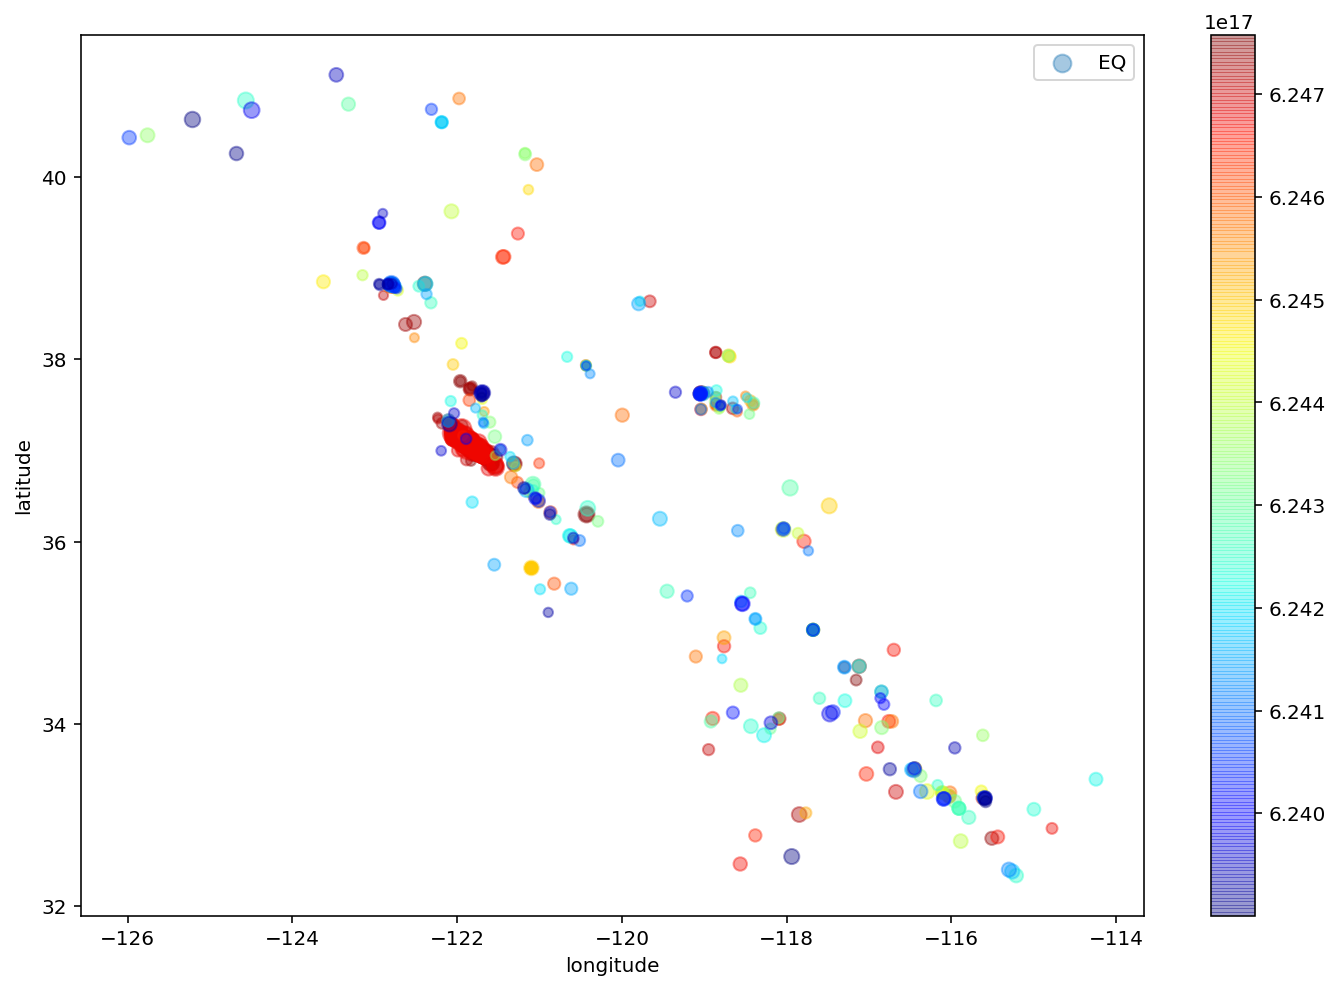

In [12]:
ax = plt.gca()

df_lp_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

### Parkfield earthquake!

In [13]:
file_path = "../datasets/" + "eq_parkfield" + "_clean" + ".csv"

df_pf_eq = pd.read_csv(file_path)
df_pf_eq.drop(columns = "Unnamed: 0", inplace = True)

df_pf_eq.set_index('time', inplace=True)




df_pf_eq.head()

,index,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
time,,,,,,,,,,,,,,,,
2004-09-28 23:57:30.850,0,earthquake,1.94,Central California,reviewed,0,58,nc,11,0.16760,0.1500,237.00,md,-120.732333,35.621500,1.545
2004-09-28 23:57:09.390,1,earthquake,1.25,Central California,reviewed,0,24,nc,25,0.02342,0.0500,110.00,md,-120.483500,35.935667,5.004
2004-09-28 23:55:09.050,2,earthquake,1.79,Central California,automatic,0,49,nc,12,0.02432,0.0700,99.00,md,-120.431500,35.886000,6.401
2004-09-28 23:55:07.289,3,earthquake,1.30,Central California,reviewed,0,26,nn,5,0.05000,0.0431,96.31,mb,-118.668500,38.002500,6.000
2004-09-28 23:53:13.850,4,earthquake,1.20,"5km SSE of Redlands, California",reviewed,0,22,ci,9,0.04061,0.0700,153.00,mh,-117.153833,34.013833,15.856


Checking for datatypes or missing values!

In [14]:
df_pf_eq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 2004-09-28 23:57:30.850 to 2004-09-20 15:59:25.390
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      2000 non-null   int64  
 1   type       2000 non-null   object 
 2   mag        2000 non-null   float64
 3   place      2000 non-null   object 
 4   status     2000 non-null   object 
 5   tsunami    2000 non-null   int64  
 6   sig        2000 non-null   int64  
 7   net        2000 non-null   object 
 8   nst        2000 non-null   int64  
 9   dmin       1999 non-null   float64
 10  rms        2000 non-null   float64
 11  gap        2000 non-null   float64
 12  magType    2000 non-null   object 
 13  longitude  2000 non-null   float64
 14  latitude   2000 non-null   float64
 15  depth      2000 non-null   float64
dtypes: float64(7), int64(4), object(5)
memory usage: 265.6+ KB


Taking care of time index!

In [15]:
df_pf_eq.index = pd.to_datetime(df_pf_eq.index)

df_pf_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2004-09-28 23:57:30.850000 to 2004-09-20 15:59:25.390000
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      2000 non-null   int64  
 1   type       2000 non-null   object 
 2   mag        2000 non-null   float64
 3   place      2000 non-null   object 
 4   status     2000 non-null   object 
 5   tsunami    2000 non-null   int64  
 6   sig        2000 non-null   int64  
 7   net        2000 non-null   object 
 8   nst        2000 non-null   int64  
 9   dmin       1999 non-null   float64
 10  rms        2000 non-null   float64
 11  gap        2000 non-null   float64
 12  magType    2000 non-null   object 
 13  longitude  2000 non-null   float64
 14  latitude   2000 non-null   float64
 15  depth      2000 non-null   float64
dtypes: float64(7), int64(4), object(5)
memory usage: 265.6+ KB


In [16]:
df_pf_eq.head()

,index,type,mag,place,status,tsunami,sig,net,nst,dmin,rms,gap,magType,longitude,latitude,depth
time,,,,,,,,,,,,,,,,
2004-09-28 23:57:30.850,0,earthquake,1.94,Central California,reviewed,0,58,nc,11,0.16760,0.1500,237.00,md,-120.732333,35.621500,1.545
2004-09-28 23:57:09.390,1,earthquake,1.25,Central California,reviewed,0,24,nc,25,0.02342,0.0500,110.00,md,-120.483500,35.935667,5.004
2004-09-28 23:55:09.050,2,earthquake,1.79,Central California,automatic,0,49,nc,12,0.02432,0.0700,99.00,md,-120.431500,35.886000,6.401
2004-09-28 23:55:07.289,3,earthquake,1.30,Central California,reviewed,0,26,nn,5,0.05000,0.0431,96.31,mb,-118.668500,38.002500,6.000
2004-09-28 23:53:13.850,4,earthquake,1.20,"5km SSE of Redlands, California",reviewed,0,22,ci,9,0.04061,0.0700,153.00,mh,-117.153833,34.013833,15.856


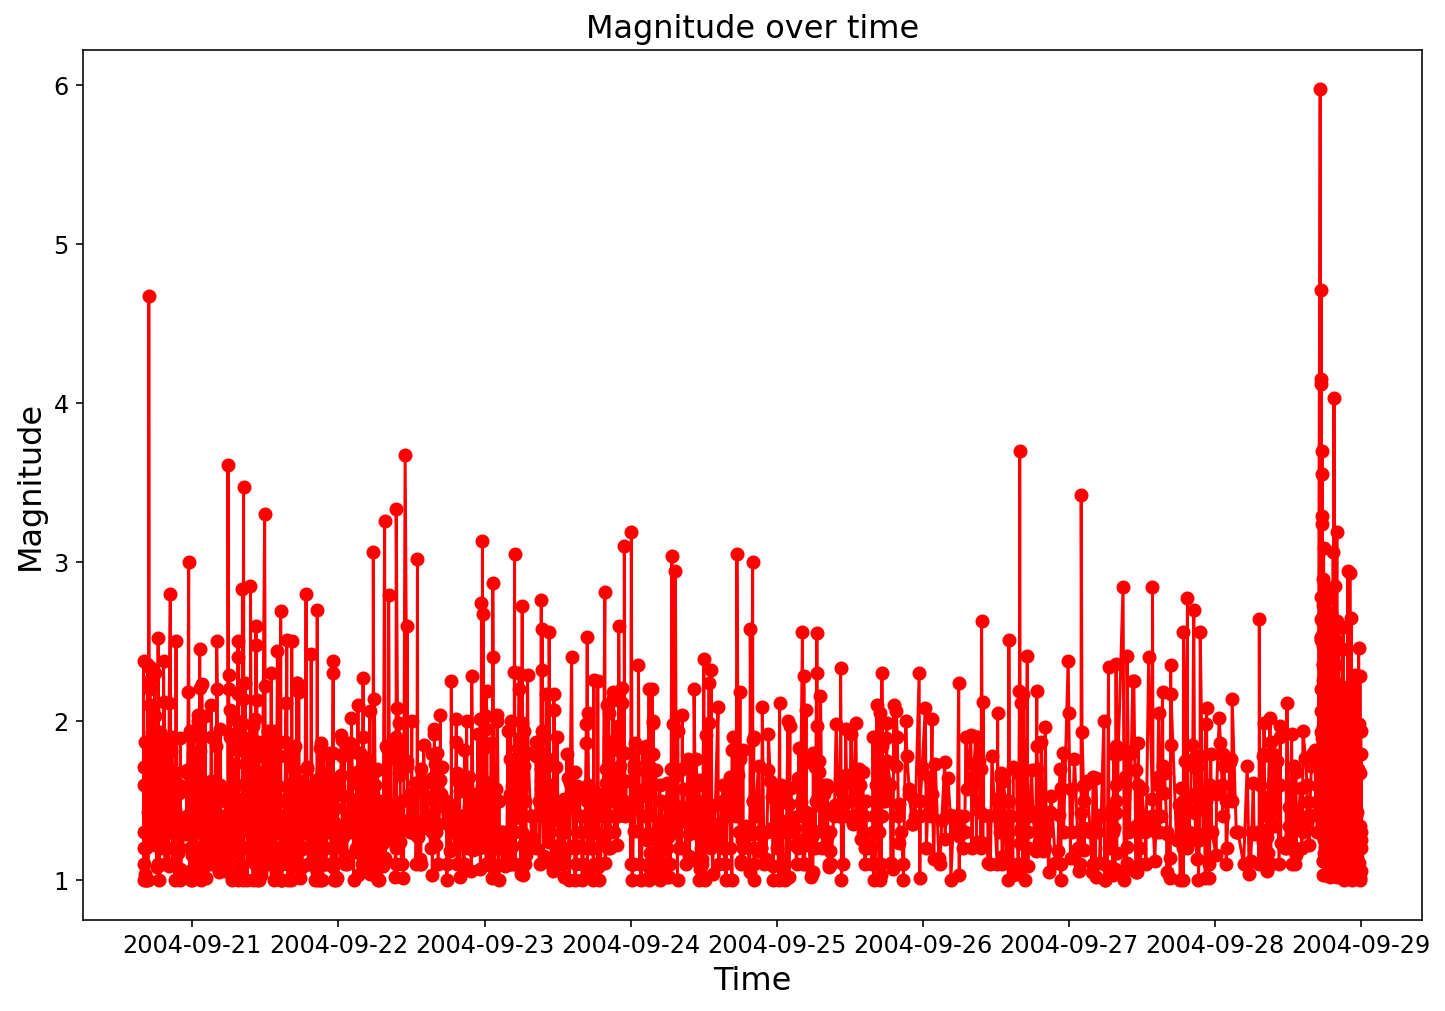

In [17]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_pf_eq["mag"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)

plt.title('Magnitude over time', fontsize=16);

Figure suggests that the main shock, which had magnitude of 7 was just a spike in magnitude domain!

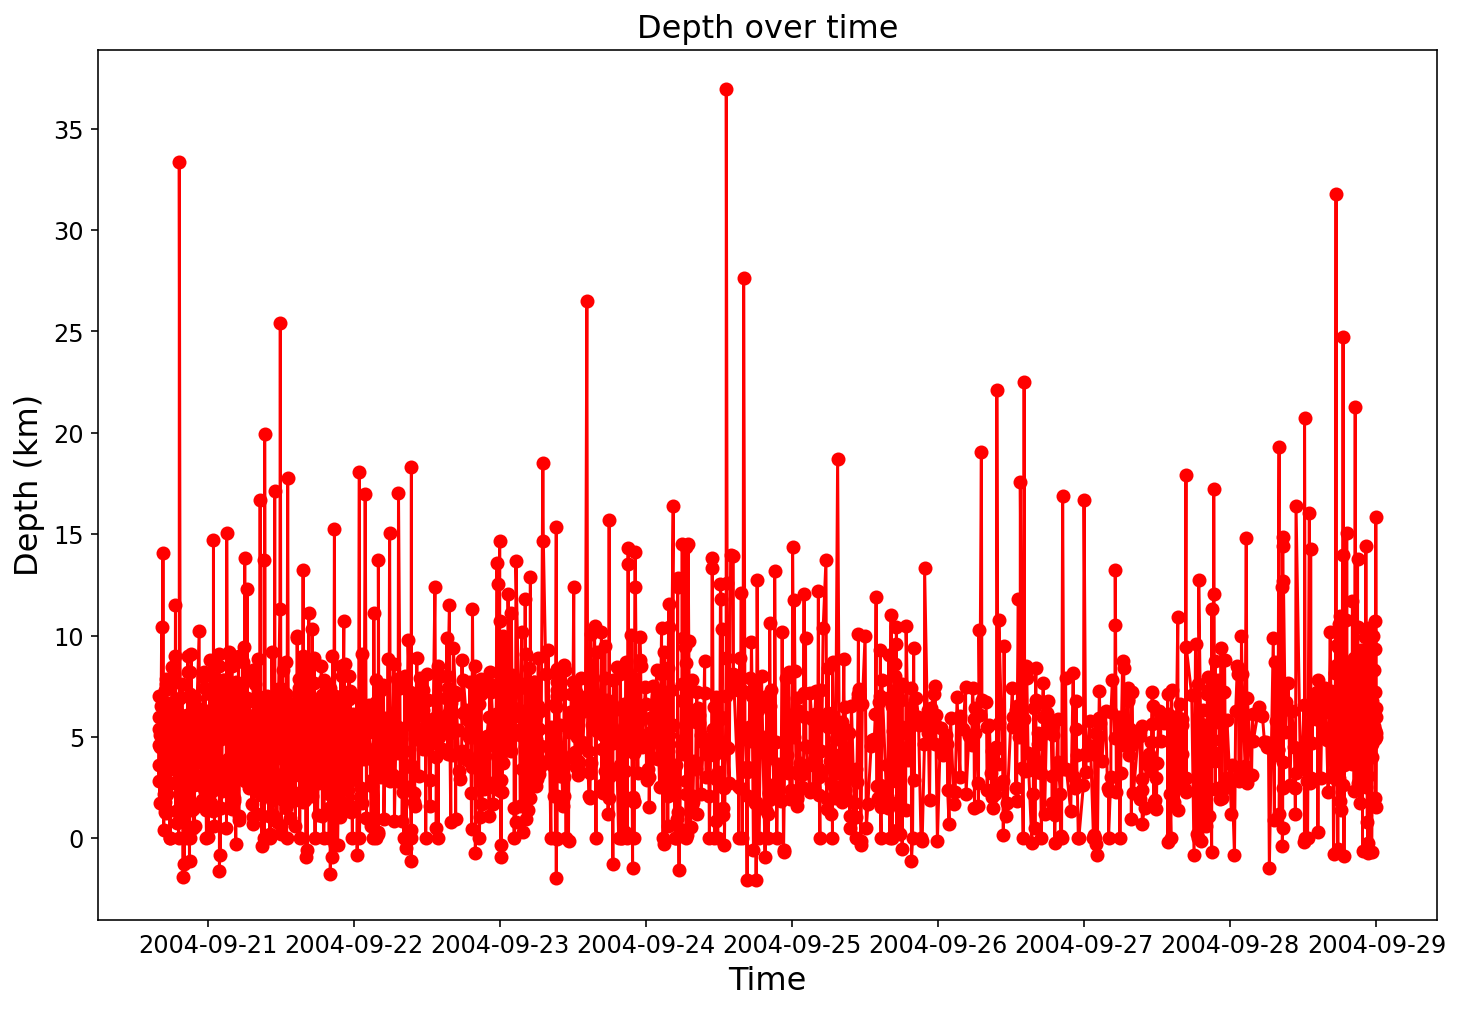

In [18]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_pf_eq["depth"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Depth (km)', fontsize=16)
plt.title('Depth over time', fontsize=16);

Same goes for depth!

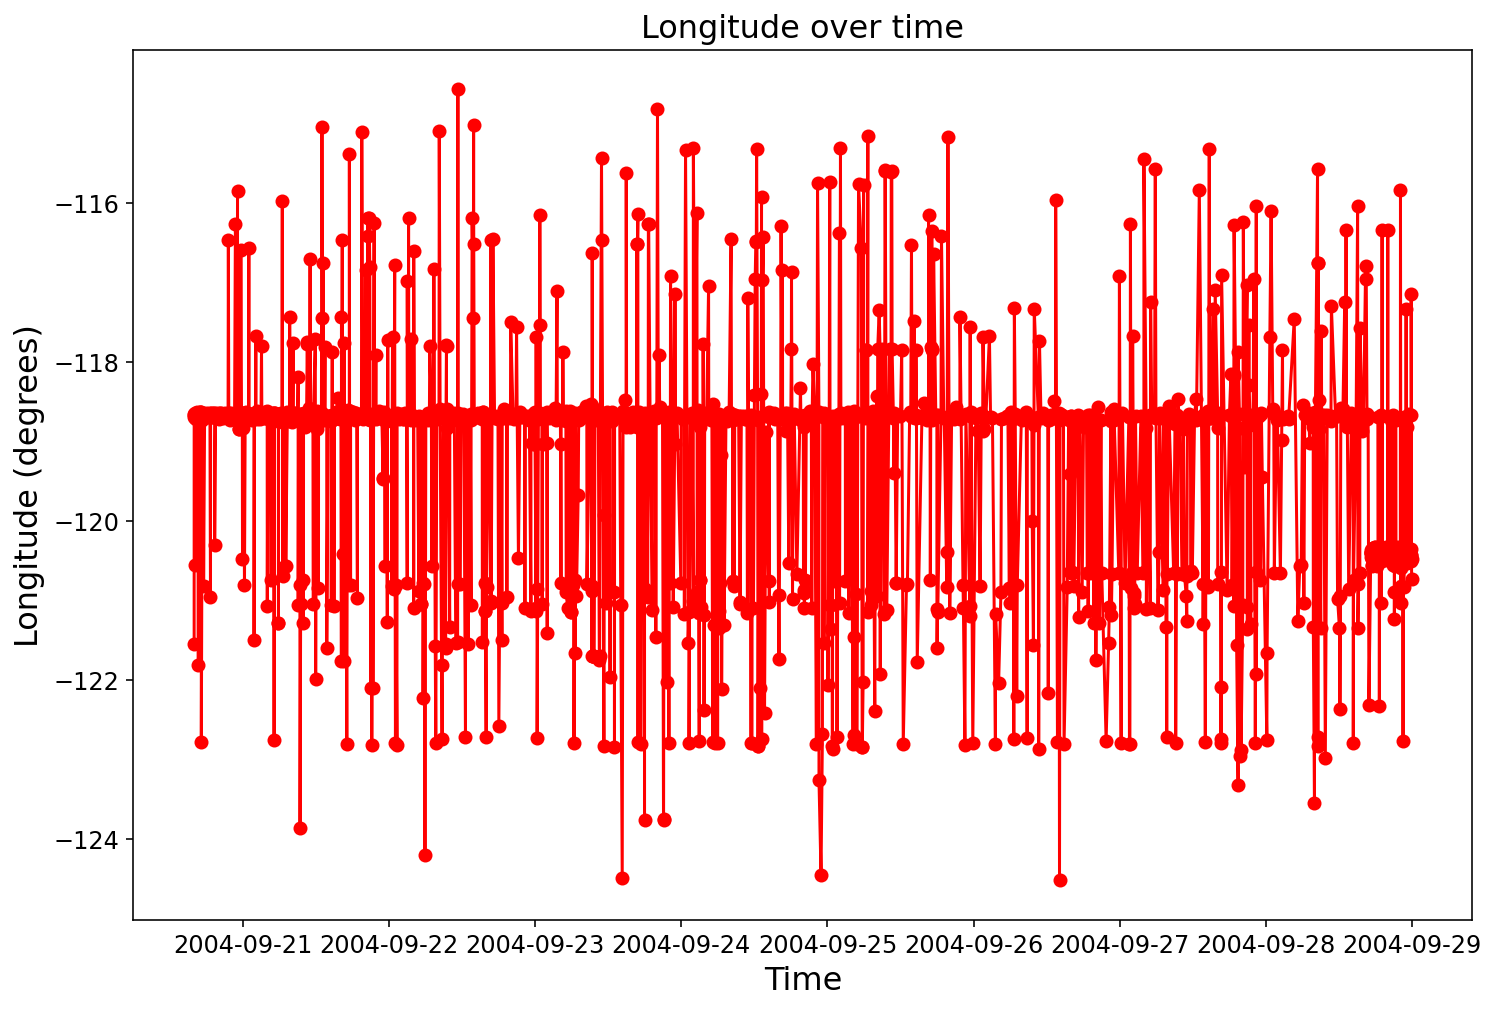

In [19]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_pf_eq["longitude"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Longitude (degrees)', fontsize=16)
plt.title('Longitude over time', fontsize=16);

Same goes for Longitude!

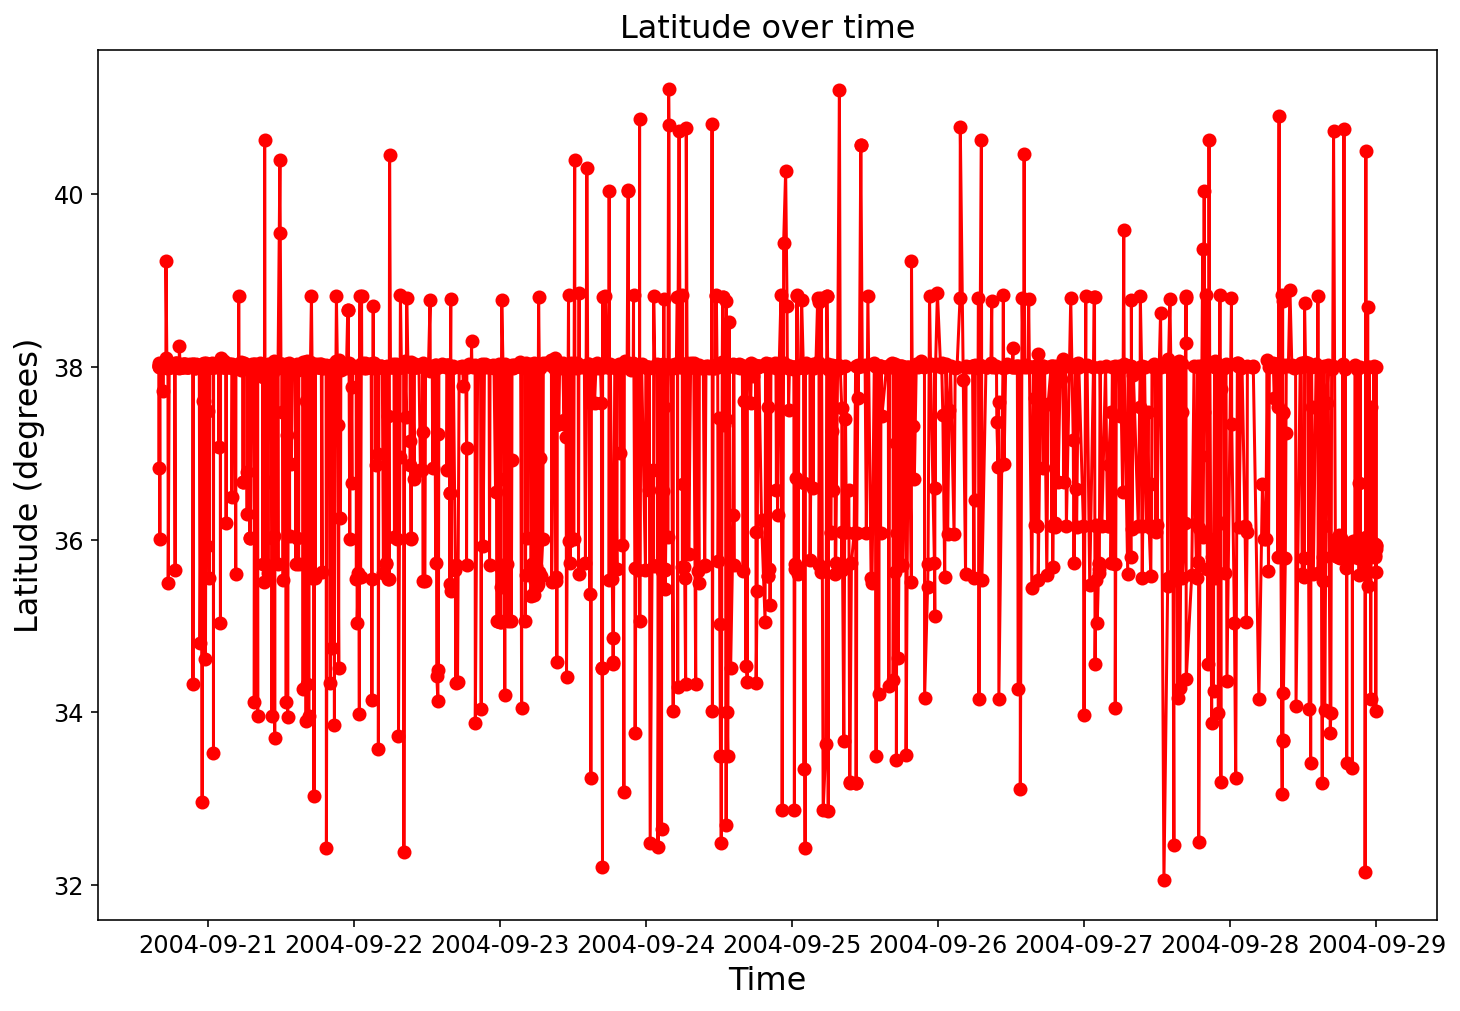

In [20]:
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12,8))
plt.plot(df_pf_eq["latitude"], 'o-', c = "red")

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Latitude (degrees)', fontsize=16)
plt.title('Latitude over time', fontsize=16);

Same goes for depth!

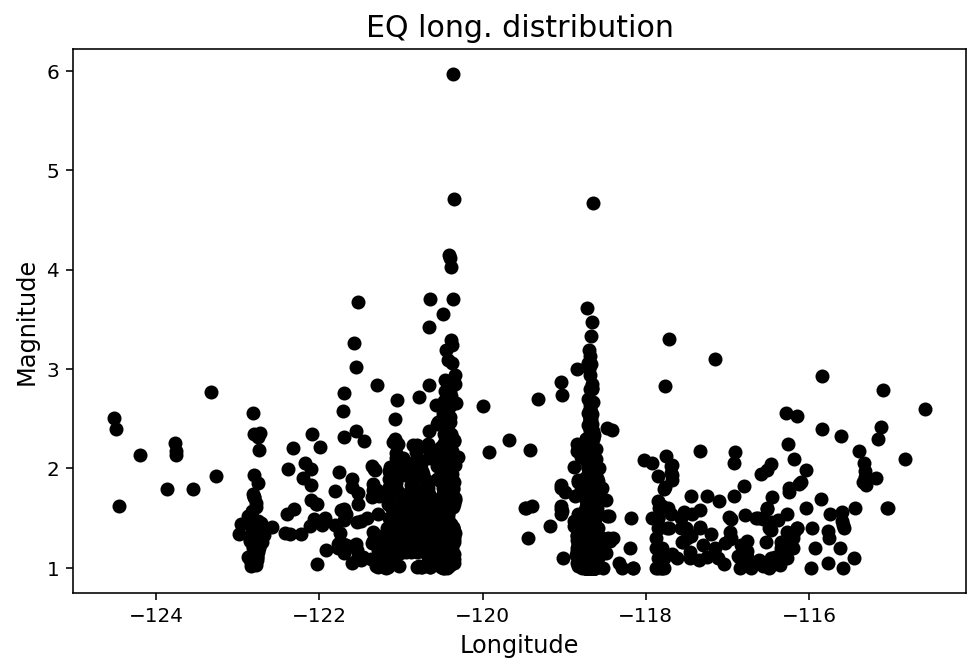

In [21]:
plt.figure(figsize = [8, 5])

plt.scatter(df_pf_eq["longitude"], df_pf_eq["mag"], color="black");

# Format title and axis labels
plt.title("EQ long. distribution", fontsize = 15);

plt.xlabel("Longitude", fontsize = 12);
plt.ylabel("Magnitude", fontsize = 12);

In addition to the main fault activites, there was a parallel fault (presumably) active as well!

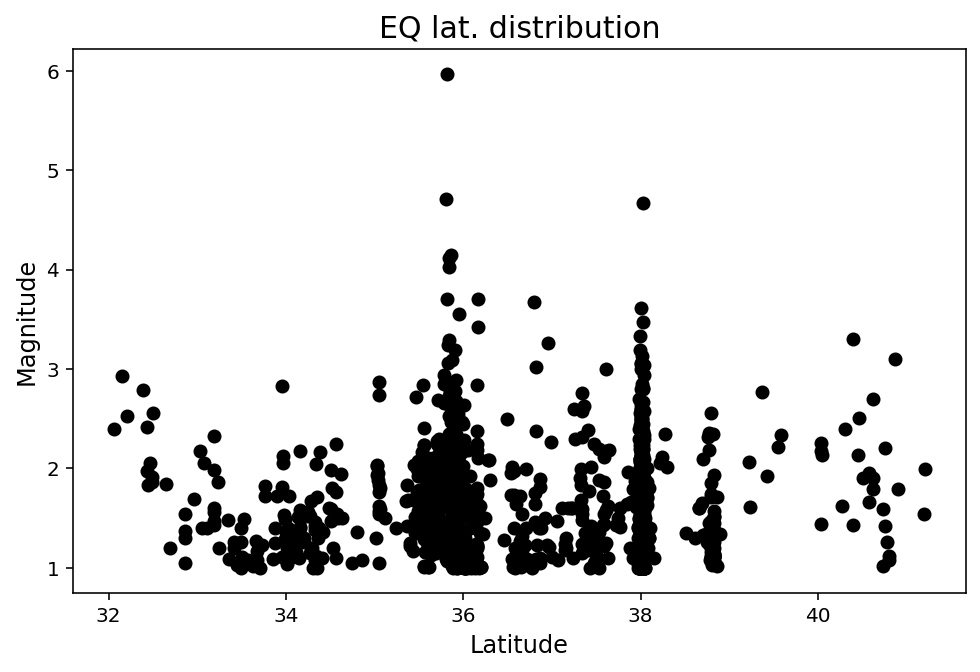

In [22]:
plt.figure(figsize = [8, 5])

plt.scatter(df_pf_eq["latitude"], df_pf_eq["mag"], color="black");

# Format title and axis labels
plt.title("EQ lat. distribution", fontsize = 15);

plt.xlabel("Latitude", fontsize = 12);
plt.ylabel("Magnitude", fontsize = 12);

In addition to the main fault activites, there was a parallel fault (presumably) active as well!

### Now, looking at tempral earthquake focus points

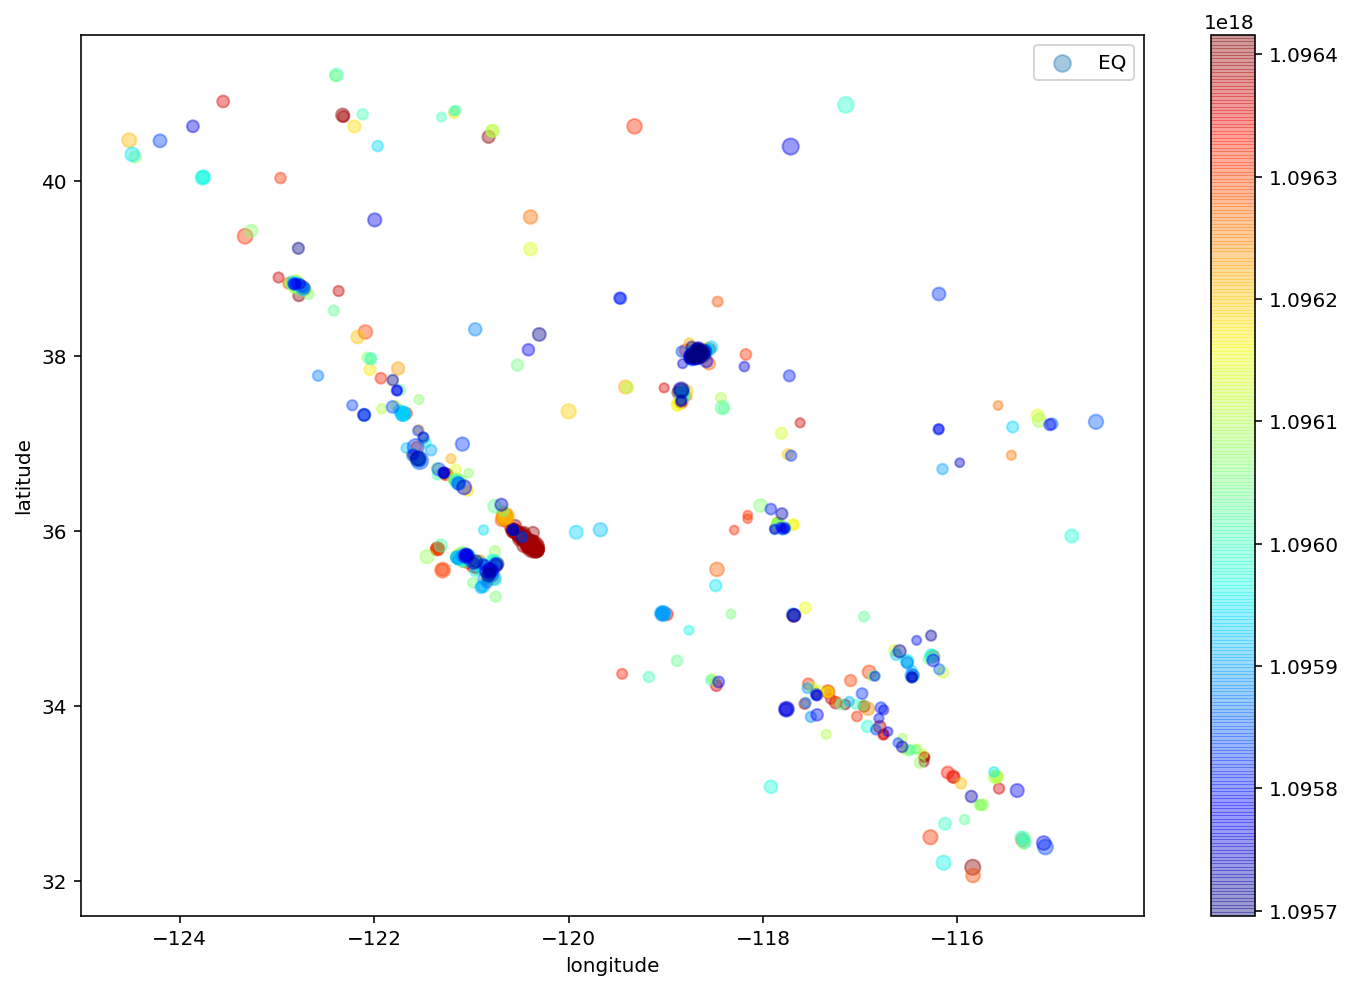

In [23]:
ax = plt.gca()


df_pf_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_pf_eq['mag']/0.05, label="EQ",
    c=df_pf_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

In [24]:
print("Hello World!")

Hello World!
